# 라이브러리 및 데이터

### 라이브러리

In [29]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import random # 시드 제어
from pandas import Series, DataFrame
import sys
import time
import re

import seaborn as sns
import matplotlib.pyplot as plt # 시각화
%matplotlib inline

import datetime
from workalendar.asia import SouthKorea # 한국의 공휴일

import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor # 모델링
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
import catboost as cb

import shap
import skimage

# 시드
import os
seed = 12345
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

### 데이터셋 처리 및 분류

In [2]:
# load dataset
final_ans = pd.read_csv('section_2week.csv', sep=',')
final_ans_test = pd.read_csv('section_2week_test.csv', sep=',')

final = pd.concat([final_ans, final_ans_test])
final = final.reset_index()
del final['index']

final = final.sort_values(by=['date'], axis=0)

# date의 데이터 형식이 'yyyy-mm-dd'인 string이어서 lightgbm 내부에서 float으로 데이터를 변형시키지
# 못하여 데이터의 형식을 'yyyymmdd'로 변환
date_lst = []
for value in final['date'].values:
    val = re.sub(r"[-]","",value)
    date_lst.append(val)
final['date'] = date_lst

X = final[final_ans.columns.difference(['power'])]
Y = final['power']

X['date'] = X['date'].astype(float)

col = ['date','day','dayofweek','holiday','min_temp','month','power_d',
       'power_d1','power_d10','power_d11','power_d12','power_d13','power_d14',
       'power_d2','power_d3','power_d4','power_d5','power_d6','power_d7',
       'power_d8','power_d9','week','weekend','year']
X_not = X[col]
X_not['date'] = X_not['date'].astype(float)

x_train, x_valtest, y_train, y_valtest = train_test_split(X_not, Y, test_size = 0.2, shuffle=False, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, shuffle=False, random_state=seed)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(83271, 24) (83271,) (10409, 24) (10409,) (10409, 24) (10409,)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# lightGBM

In [3]:
train_lgb = lgb.Dataset(x_train, label = y_train)
val_lgb = lgb.Dataset(x_val, label = y_val)
params = {'random_seed':seed, 'bagging_seed':seed,
          'feature_fraction_seed':seed, 'data_random_seed':seed,
          'drop_seed':seed,
          'num_iterations':400,
          'boosting_type':'gbdt', 'objective':'regression_l1',
          'learning_rate':0.05, 'num_leaves':100, 'max_depth':-1,
          'bagging_fraction':0.1, 'feature_fraction':0.8,
          'lambda_l1':0.0, 'lambda_l2':15.0, 'max_bin':300}
model = lgb.train(params, train_lgb, valid_sets = val_lgb,
                  num_boost_round = 2000, early_stopping_rounds = 100,
                  verbose_eval = 200)

Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0316913
Early stopping, best iteration is:
[275]	valid_0's l1: 0.0316692


In [4]:
lgb_test, lgb_valid = model.predict(x_test), model.predict(x_val)

In [5]:
def smape(array_1, array_2):
    score = 100*np.mean(2*abs(array_1 - array_2)/(abs(array_1)+abs(array_2)))
    return score

In [6]:
# predict과 test set의 smape 계산
lgb_test_smape, lgb_valid_smape = smape(lgb_test, y_test), smape(lgb_valid, y_val)

print(lgb_valid_smape)
print(lgb_test_smape)

12.35703830075168
12.890580864703786


In [7]:
#np.savetxt('data/lgb_test.csv', lgb_test, delimiter=',')
#np.savetxt('data/y_test.csv', y_test, delimiter=',')

# lightGBM 결과 분석

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


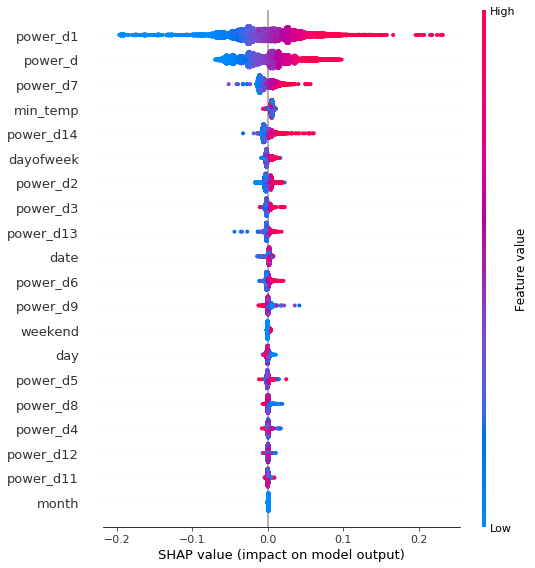

In [9]:
shap.summary_plot(shap_values, x_test)

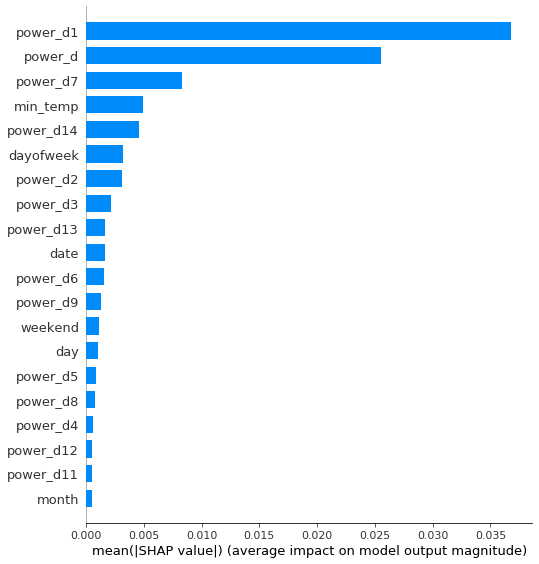

In [10]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

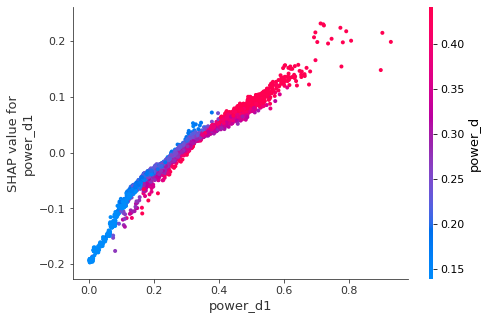

In [11]:
shap.dependence_plot('power_d1', shap_values, x_test)

# Decision tree

In [12]:
tree = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                             max_features=len(col),
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, min_samples_leaf=1,
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             presort='deprecated', random_state=seed, splitter='best')

In [13]:
tree_fit = tree.fit(x_train, y_train)
predictions = tree_fit.predict(x_test)
validations = tree_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

13.86752467603572
13.976457645694316


# Random forest

In [14]:
rand_tree = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=None,
                                  min_samples_split=2, min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0, max_features=len(col),
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                  bootstrap=True, oob_score=False, n_jobs=None, random_state=seed,
                                  verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

In [15]:
rand_tree_fit = rand_tree.fit(x_train, y_train)
predictions = rand_tree_fit.predict(x_test)
validations = rand_tree_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

12.848769831702006
13.504408961040395


# Bagging

In [16]:
bagging_tree = BaggingRegressor(base_estimator=tree, n_estimators=30,
                                max_samples=1.0, max_features=1.0, bootstrap=True,
                                bootstrap_features=False, oob_score=False,
                                warm_start=False, n_jobs=None, random_state=seed,
                                verbose=0)

In [17]:
bagging_tree_fit = bagging_tree.fit(x_train, y_train)
predictions = bagging_tree_fit.predict(x_test)
validations = bagging_tree_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

13.341365188470395
13.556228173309892


# Extra tree

In [18]:
extra_tree = ExtraTreeRegressor(criterion='mse', splitter='random', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0, max_features=len(col),
                                random_state=seed, min_impurity_decrease=0.0, min_impurity_split=None,
                                max_leaf_nodes=None, ccp_alpha=0.0)

In [19]:
extra_tree_fit = extra_tree.fit(x_train, y_train)
predictions = extra_tree_fit.predict(x_test)
validations = extra_tree_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

18.235221919993506
18.566550143925717


# Adaboost

In [20]:
adabst = AdaBoostRegressor(base_estimator=None, n_estimators=50,
                           learning_rate=1.0, loss='linear', random_state=None)

In [21]:
adabst_fit = adabst.fit(x_train, y_train)
predictions = adabst_fit.predict(x_test)
validations = adabst_fit.predict(x_val)
test_score = smape(predictions, y_test)
val_score = smape(validations, y_val)
print(val_score)
print(test_score)

19.650498279321486
19.49627449888579


# Xgboost

In [32]:
start = time.time()

train_xgb = xgb.DMatrix(data = x_train, label = y_train)
val_xgb = xgb.DMatrix(data = x_val, label = y_val)
test_xgb = xgb.DMatrix(data = x_test, label = y_test)

xgb_param = {'max_depth': 10, # 트리 깊이
           'learning_rate': 0.01, # Step Size
           'n_estimators': 100, # Number of trees, 트리 생성 개수
           'objective': 'reg:squarederror', # 목적 함수
           'num_class': len(set(y_train)) + 1}
# 파라미터 추가, Label must be in [0, num_class] -> num_class보다 1 커야한다.

xgb_model = xgb.train(params = xgb_param, dtrain = train_xgb) # 학습 진행

xgb_model_val_predict = xgb_model.predict(val_xgb) # 검증 데이터 예측
xgb_model_predict = xgb_model.predict(test_xgb) # 평가 데이터 예측

xgb_test_smape, xgb_valid_smape = smape(xgb_model_predict, y_test), smape(xgb_model_val_predict, y_val)

print(xgb_valid_smape)
print(xgb_test_smape)
print("Time: %.2f" % (time.time() - start)) # 코드 실행 시간 계산

[15:40:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




OSError: [WinError -529697949] Windows Error 0xe06d7363

# Catboost

In [31]:
start = time.time()
train_cb = cb.Pool(data = x_train, label = y_train)
val_cb = cb.Pool(data = x_val, label = y_val)
test_cb = cb.Pool(data = x_test, label = y_test)

cb_param = {'max_depth': 10, # 트리 깊이
           'learning_rate': 0.01, # Step Size
           'n_estimators': 100, # Number of trees, 트리 생성 개수
           'eval_metric': 'SMAPE', # 목적 함수
           'loss_function': 'RMSE'}
# 파라미터 추가, Label must be in [0, num_class] -> num_class보다 1 커야한다.

cb_model = cb.train(params = cb_param, pool = train_cb) # 학습 진행

cb_model_val_predict = cb_model.predict(val_cb) # 검증 데이터 예측
cb_model_predict = cb_model.predict(test_cb) # 평가 데이터 예측

cb_test_smape, cb_valid_smape = smape(cb_model_predict, y_test), smape(cb_model_val_predict, y_val)

print(cb_test_smape)
print(cb_valid_smape)
print("Time: %.2f" % (time.time() - start)) # 코드 실행 시간 계산

0:	learn: 32.6700942	total: 119ms	remaining: 11.8s
1:	learn: 32.4539350	total: 173ms	remaining: 8.48s
2:	learn: 32.2363634	total: 229ms	remaining: 7.42s
3:	learn: 32.0234350	total: 286ms	remaining: 6.86s
4:	learn: 31.8152600	total: 352ms	remaining: 6.69s
5:	learn: 31.6052207	total: 411ms	remaining: 6.44s
6:	learn: 31.4028947	total: 470ms	remaining: 6.24s
7:	learn: 31.2019416	total: 527ms	remaining: 6.06s
8:	learn: 31.0004584	total: 593ms	remaining: 5.99s
9:	learn: 30.8001775	total: 656ms	remaining: 5.9s
10:	learn: 30.5996811	total: 711ms	remaining: 5.75s
11:	learn: 30.4027615	total: 772ms	remaining: 5.66s
12:	learn: 30.2158406	total: 844ms	remaining: 5.65s
13:	learn: 30.0247743	total: 911ms	remaining: 5.6s
14:	learn: 29.8351675	total: 989ms	remaining: 5.6s
15:	learn: 29.6476364	total: 1.06s	remaining: 5.55s
16:	learn: 29.4631323	total: 1.12s	remaining: 5.47s
17:	learn: 29.2803960	total: 1.19s	remaining: 5.43s
18:	learn: 29.0980978	total: 1.27s	remaining: 5.41s
19:	learn: 28.9190319	tot